In [1]:
!pip uninstall torch torchvision torchaudio transformers datasets -y
!pip cache purge

# Install a known-good, compatible stack
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
!pip install transformers==4.41.2 datasets==2.19.2 rouge-score==0.1.2 scikit-learn matplotlib seaborn numpy tqdm
!pip install sentencepiece

Found existing installation: torch 2.3.1+cu121
Uninstalling torch-2.3.1+cu121:
  Successfully uninstalled torch-2.3.1+cu121
Found existing installation: torchvision 0.18.1+cu121
Uninstalling torchvision-0.18.1+cu121:
  Successfully uninstalled torchvision-0.18.1+cu121
Found existing installation: torchaudio 2.3.1+cu121
Uninstalling torchaudio-2.3.1+cu121:
  Successfully uninstalled torchaudio-2.3.1+cu121
Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: datasets 2.19.2
Uninstalling datasets-2.19.2:
  Successfully uninstalled datasets-2.19.2
ERROR: pip cache commands can not function since cache is disabled.
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/is

In [2]:
import json
import os
import time
import warnings
from collections import defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from rouge_score import rouge_scorer
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import (
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    get_linear_schedule_with_warmup,
)

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Config:
    model_name = "google/mt5-small"
    languages = ["english", "hindi", "punjabi"]
    num_experts = 6
    top_k = 3
    capacity_factor = 1.25
    max_input_length = 512
    max_target_length = 128

    batch_size = 32 
    gradient_accumulation_steps = 1
    learning_rate = 3e-4
    num_epochs = 5
    warmup_steps = 2000
    weight_decay = 0.01
    aux_loss_weight = 0.1
    gradient_clip_val = 1.0
    
    num_beams = 4
    generation_max_length = 128
    
    LOG_INTERVALS = 500
    VALIDATION_INTERVALS = 999999
    validation_subset_size = 100
    max_val_generation_batches = 100
    num_workers = 8 

    train_size = None
    val_size = None
    test_size = None

    checkpoint_dir = "./"
    save_every_n_epochs = 1
    save_best_only = True
    best_metric = "rougeL"
    patience = 3
    min_delta = 0.001

In [4]:
config = Config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Effective Batch Size: {config.batch_size * config.gradient_accumulation_steps}")
os.makedirs(config.checkpoint_dir, exist_ok=True)

Using device: cuda
Effective Batch Size: 32


In [5]:
class ModelCheckpoint:
    def __init__(
        self,
        checkpoint_dir,
        save_best_only=True,
        best_metric="rouge1",
        patience=None,
        min_delta=0.001,
    ):
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_metric = best_metric
        self.patience = patience
        self.min_delta = min_delta

        self.best_score = float("-inf")
        self.best_epoch = 0
        self.patience_counter = 0
        self.should_stop = False

        self.best_model_dir = os.path.join(checkpoint_dir, "best_model")
        self.epoch_checkpoints_dir = os.path.join(
            checkpoint_dir, "epoch_checkpoints")

        os.makedirs(self.best_model_dir, exist_ok=True)
        os.makedirs(self.epoch_checkpoints_dir, exist_ok=True)

    def save_checkpoint(
        self,
        model,
        optimizer,
        scheduler,
        epoch,
        train_loss,
        val_loss,
        rouge_scores,
        training_history,
    ):
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "rouge_scores": rouge_scores,
            "training_history": training_history,
            "config": config.__dict__,
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "timestamp": datetime.now().isoformat(),
        }

        # Save epoch-specific checkpoint if not save_best_only
        if not self.save_best_only:
            epoch_path = os.path.join(
                self.epoch_checkpoints_dir, f"checkpoint_epoch_{epoch}.pt"
            )
            torch.save(checkpoint_data, epoch_path)
            print(f"Saved epoch checkpoint to {epoch_path}")

        # Check if this is the best model
        current_score = rouge_scores[self.best_metric]
        if current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.best_epoch = epoch
            self.patience_counter = 0

            # Save best model
            best_path = os.path.join(self.best_model_dir, "best_model.pt")
            torch.save(checkpoint_data, best_path)
            print(
                f"New best model saved! {self.best_metric}: {current_score:.4f} (epoch {epoch})"
            )

            # Also save in HuggingFace format
            model_to_save = model.module if hasattr(model, "module") else model
            model_to_save.base_model.save_pretrained(
                os.path.join(self.best_model_dir, "hf_model")
            )
        else:
            self.patience_counter += 1
            print(
                f"No improvement. Patience: {self.patience_counter}/{self.patience}")

        if self.patience and self.patience_counter >= self.patience:
            self.should_stop = True
            print(
                f"Early stopping triggered after {self.patience} epochs without improvement"
            )

        # Save metadata
        metadata = {
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "current_epoch": epoch,
            "patience_counter": self.patience_counter,
            "training_complete": False,
        }

        with open(
            os.path.join(self.checkpoint_dir, "training_metadata.json"), "w"
        ) as f:
            json.dump(metadata, f, indent=2)

    def load_checkpoint(self, checkpoint_path, model, optimizer=None, scheduler=None):
        print(f"Loading checkpoint from {checkpoint_path}")

        checkpoint = torch.load(
            checkpoint_path, map_location=device, weights_only=False
        )

        model.load_state_dict(checkpoint["model_state_dict"])

        if optimizer and "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        if scheduler and "scheduler_state_dict" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        self.best_score = checkpoint.get("best_score", float("-inf"))
        self.best_epoch = checkpoint.get("best_epoch", 0)

        print(f"Checkpoint loaded successfully!")
        print(f"Resuming from epoch {checkpoint['epoch']}")
        print(
            f"Best {self.best_metric} score so far: {self.best_score:.4f} (epoch {self.best_epoch})"
        )

        return checkpoint

In [6]:
class MoELayer(nn.Module):
    def __init__(self, hidden_size, num_experts, top_k, capacity_factor):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_experts = num_experts
        self.top_k = top_k
        self.capacity_factor = capacity_factor

        # Gating network - added bias for more routing flexibility
        self.gate = nn.Linear(hidden_size, num_experts, bias=True)

        # Expert networks (FFN layers)
        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size * 4),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(hidden_size * 4, hidden_size),
                )
                for _ in range(num_experts)
            ]
        )

        # Language expert mapping
        self.language_expert_map = {
            "en": 0, "hi": 1, "pa": 2, "shared": [3, 4, 5]}
        
        # Track overflow statistics
        self.overflow_count = 0
        self.total_forward_calls = 0

    def forward(self, x, language_ids=None):
        batch_size, seq_len, hidden_size = x.shape
        x_flat = x.view(-1, hidden_size)  # [batch_size * seq_len, hidden_size]
        num_tokens = x_flat.size(0)

        # Gating with optional language-aware biasing
        gate_logits = self.gate(x_flat)  # [num_tokens, num_experts]
        
        # Language-aware routing: boost probability for language-specific experts
        if language_ids is not None and self.training:
            # Expand language_ids to all tokens in sequence
            lang_bias = torch.zeros_like(gate_logits)
            
            for batch_idx, lang_id in enumerate(language_ids):
                # Apply bias to all tokens in this sample
                start_idx = batch_idx * seq_len
                end_idx = start_idx + seq_len
                
                if lang_id in self.language_expert_map:
                    expert_idx = self.language_expert_map[lang_id]
                    if isinstance(expert_idx, list):
                        # Boost shared experts
                        for idx in expert_idx:
                            lang_bias[start_idx:end_idx, idx] = 0.5
                    else:
                        # Strong boost for language-specific expert
                        lang_bias[start_idx:end_idx, expert_idx] = 1.0
            
            gate_logits = gate_logits + lang_bias
        
        gate_probs = F.softmax(gate_logits, dim=-1)  # [num_tokens, num_experts]

        # Top-k gating - vectorized
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)  # Normalize

        capacity = int(self.capacity_factor * num_tokens / self.num_experts)

        target_dtype = torch.float16 if torch.is_autocast_enabled() else x_flat.dtype
        expert_outputs = torch.zeros_like(x_flat, dtype=target_dtype)
        expert_usage = torch.zeros(self.num_experts, device=x.device)

        for expert_idx in range(self.num_experts):
            expert_mask = (top_k_indices == expert_idx).any(dim=-1)
            
            if not expert_mask.any():
                continue
            
            token_indices = torch.where(expert_mask)[0]
            expert_input = x_flat[expert_mask]
            
            expert_weights = torch.zeros(expert_input.size(0), device=x.device, dtype=target_dtype)
            for k_idx in range(self.top_k):
                matches = (top_k_indices[token_indices, k_idx] == expert_idx)
                expert_weights[matches] += top_k_probs[token_indices[matches], k_idx]
            
            if expert_input.size(0) > capacity:
                _, top_indices = torch.topk(expert_weights, k=capacity, largest=True)
                token_indices = token_indices[top_indices]
                expert_input = expert_input[top_indices]
                expert_weights = expert_weights[top_indices]
            
            expert_output = self.experts[expert_idx](expert_input)
            expert_usage[expert_idx] = expert_input.size(0)
            
            weighted_output = expert_output * expert_weights.unsqueeze(-1)
            expert_outputs.index_add_(0, token_indices, weighted_output)

        aux_loss = torch.tensor(0.0, device=x.device)
        if self.training:
            expert_fraction = expert_usage / num_tokens
            uniform_target = 1.0 / self.num_experts
            aux_loss = ((expert_fraction - uniform_target) ** 2).sum()

        output = expert_outputs.view(batch_size, seq_len, hidden_size)
        return output, aux_loss, expert_usage

In [7]:
class MT5WithMoE(nn.Module):
    def __init__(self, base_model, num_experts, top_k, capacity_factor):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config
        self.current_language_ids = None

        self._replace_ffn_with_moe(num_experts, top_k, capacity_factor)

    def _replace_ffn_with_moe(self, num_experts, top_k, capacity_factor):
        hidden_size = self.config.d_model

        for layer in self.base_model.encoder.block:
            if hasattr(layer.layer[1], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor
                )
                layer.layer[1].DenseReluDense = MoEWrapper(moe_layer_instance, self)

        for layer in self.base_model.decoder.block:
            if hasattr(layer.layer[2], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor
                )
                layer.layer[2].DenseReluDense = MoEWrapper(moe_layer_instance, self)

    def forward(self, input_ids, attention_mask=None, labels=None, language_ids=None):
        self.current_language_ids = language_ids
        
        aux_losses = []
        expert_usage_stats = defaultdict(list)
        hooks = []

        def hook_fn(module, input, output):
            if isinstance(module, MoELayer):
                _, aux_loss, expert_usage = output
                aux_losses.append(aux_loss.to(input_ids.device))
                expert_usage_stats[id(module)].append(expert_usage)

        try:
            for module in self.modules():
                if isinstance(module, MoELayer):
                    hook = module.register_forward_hook(hook_fn)
                    hooks.append(hook)

            outputs = self.base_model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )

            if aux_losses:
                total_aux_loss = sum(aux_losses) / len(aux_losses)
                if hasattr(outputs, "loss") and outputs.loss is not None:
                    outputs.loss += config.aux_loss_weight * total_aux_loss

        finally:
            for hook in hooks:
                hook.remove()
            self.current_language_ids = None

        return outputs

In [8]:
class MoEWrapper(nn.Module):
    def __init__(self, moe_layer, parent_model):
        super().__init__()
        self.moe_layer = moe_layer
        import weakref
        self._parent_model = weakref.ref(parent_model)

    def forward(self, x, *args, **kwargs):
        parent = self._parent_model()
        language_ids = parent.current_language_ids if parent else None
        output_tensor, aux_loss, expert_usage = self.moe_layer(x, language_ids=language_ids)
        return output_tensor

In [9]:
class MultilingualSummarizationDataset(Dataset):
    def __init__(self, tokenizer, data, max_input_length, max_target_length):
        self.tokenizer = tokenizer
        self.data = data
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

        # Add language tokens
        special_tokens = ["<en>", "<hi>", "<pa>"]
        self.tokenizer.add_special_tokens(
            {"additional_special_tokens": special_tokens})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        lang_token = f"<{item['id'].split('.')[0]}>"
        input_text = f"{lang_token} summarize: {item['text']}"
        target_text = item["target"]

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": input_encoding.input_ids.squeeze(),
            "attention_mask": input_encoding.attention_mask.squeeze(),
            "labels": target_encoding.input_ids.squeeze(),
            "language": item["id"].split(".")[0],
        }

In [10]:
def load_and_preprocess_data():
    train_data = []
    val_data = []
    test_data = []

    DATASET_NAME = "csebuetnlp/xlsum"

    for lang in config.languages:
        print(f"Loading {lang} data...")

        if config.train_size is None:
            train_split = load_dataset(DATASET_NAME, lang, split="train")
        else:
            train_per_lang = config.train_size // len(config.languages)
            train_split = load_dataset(DATASET_NAME, lang, split=f"train[:{train_per_lang}]")
        
        train_items = []
        for item in train_split:
            train_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(train_items)}",
                }
            )

        if config.val_size is None:
            val_split = load_dataset(DATASET_NAME, lang, split="validation")
        else:
            val_per_lang = config.val_size // len(config.languages)
            val_split = load_dataset(DATASET_NAME, lang, split=f"validation[:{val_per_lang}]")
        
        val_items = []
        for item in val_split:
            val_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(val_items)}",
                }
            )

        if config.test_size is None:
            test_split = load_dataset(DATASET_NAME, lang, split="test")
        else:
            test_per_lang = config.test_size // len(config.languages)
            test_split = load_dataset(DATASET_NAME, lang, split=f"test[:{test_per_lang}]")
        
        test_items = []
        for item in test_split:
            test_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(test_items)}",
                }
            )

        train_data.extend(train_items)
        val_data.extend(val_items)
        test_data.extend(test_items)

        print(
            f"{lang} - Train: {len(train_items)}, Val: {len(val_items)}, Test: {len(test_items)}"
        )

    np.random.shuffle(train_data)
    np.random.shuffle(val_data)
    np.random.shuffle(test_data)

    print(
        f"Total dataset sizes - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}"
    )

    return train_data, val_data, test_data

In [11]:
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    return {
        "rouge1": np.mean(rouge1_scores),
        "rouge2": np.mean(rouge2_scores),
        "rougeL": np.mean(rougeL_scores),
    }

In [12]:
def generate_and_decode(model, input_ids, attention_mask, labels, tokenizer):
    """Helper function to generate predictions and decode both predictions and references.
    
    Returns:
        tuple: (pred_texts, ref_texts) or (None, None) if generation fails
    """
    import time
    try:
        model_to_generate = model.module if hasattr(model, "module") else model
        
        # Time the generation phase (beam search)
        gen_start = time.time()
        generated_ids = model_to_generate.base_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=config.generation_max_length,
            num_beams=config.num_beams,
            early_stopping=True,
        )
        gen_time = time.time() - gen_start

        # Time the decoding phase
        decode_start = time.time()
        pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Decode references
        labels_copy = labels.clone()
        labels_copy[labels_copy == -100] = tokenizer.pad_token_id
        ref_texts = tokenizer.batch_decode(labels_copy, skip_special_tokens=True)
        decode_time = time.time() - decode_start
        
        # Print timing for first batch only
        if not hasattr(generate_and_decode, '_first_call_done'):
            print(f"[DEBUG] First generation: beam search took {gen_time:.3f}s, decode took {decode_time:.3f}s")
            generate_and_decode._first_call_done = True
        
        return pred_texts, ref_texts
    except RuntimeError as e:
        print(f"[Warning] Generation failed: {str(e)}")
        return None, None


def validate(model, val_loader, tokenizer, use_subset=False, subset_size=None):
    """Runs a validation cycle and returns loss and scores.
    
    Args:
        model: The model to validate
        val_loader: Validation data loader
        tokenizer: Tokenizer for decoding
        use_subset: If True, only validate on a subset of data
        subset_size: Number of batches to use for subset validation
    """
    import time
    
    total_start_time = time.time()
    
    if use_subset:
        print(f"Running quick validation on {subset_size} batches...")
    else:
        print("Running full validation...")
    
    print(f"[DEBUG] Setting model to eval mode...")
    eval_start = time.time()
    model.eval()
    print(f"[DEBUG] Model eval mode set in {time.time() - eval_start:.3f}s")
    
    val_loss = 0
    val_predictions = []
    val_references = []
    batches_processed = 0
    
    batches_to_process = subset_size if use_subset and subset_size else len(val_loader)
    
    data_transfer_time = 0
    forward_pass_time = 0
    generation_time = 0
    decode_time = 0

    print(f"[DEBUG] Starting validation loop for {batches_to_process} batches...")
    loop_start = time.time()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if batch_idx == 0:
                print(f"[DEBUG] First batch retrieved in {time.time() - loop_start:.3f}s")
            
            if use_subset and batch_idx >= batches_to_process:
                break
            
            # Time data transfer
            transfer_start = time.time()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            data_transfer_time += time.time() - transfer_start

            # Time forward pass
            forward_start = time.time()
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
            forward_pass_time += time.time() - forward_start

            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
            val_loss += loss.item()
            batches_processed += 1

            # Time generation
            gen_start = time.time()
            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer
            )
            generation_time += time.time() - gen_start
            
            if pred_texts is not None:
                val_predictions.extend(pred_texts)
                val_references.extend(ref_texts)
            
            if batch_idx == 0:
                print(f"[DEBUG] First batch completed in {time.time() - loop_start:.3f}s")

    print(f"\n[DEBUG] Validation Loop Timings:")
    print(f"  - Data transfer to GPU: {data_transfer_time:.3f}s ({data_transfer_time/batches_processed:.3f}s per batch)")
    print(f"  - Forward pass (loss): {forward_pass_time:.3f}s ({forward_pass_time/batches_processed:.3f}s per batch)")
    print(f"  - Generation (beam search): {generation_time:.3f}s ({generation_time/batches_processed:.3f}s per batch)")
    print(f"  - Total loop time: {time.time() - loop_start:.3f}s")
    
    # Time ROUGE calculation
    rouge_start = time.time()
    avg_val_loss = val_loss / max(batches_processed, 1)
    rouge_scores = calculate_rouge_scores(val_predictions, val_references) if val_predictions else {
        "rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0
    }
    rouge_time = time.time() - rouge_start
    print(f"  - ROUGE calculation: {rouge_time:.3f}s")

    model.train()  # Set model back to training mode
    
    print(f"[DEBUG] Total validation time: {time.time() - total_start_time:.3f}s")
    print(f"[DEBUG] Batches processed: {batches_processed}")
    
    return avg_val_loss, rouge_scores

In [13]:
def train_model(
    model, train_loader, val_loader, tokenizer, resume_from_checkpoint=None
):
    optimizer = AdamW(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=total_steps
    )

    # Initialize GradScaler with conservative settings for H100
    scaler = torch.cuda.amp.GradScaler(
        init_scale=2**10,  # Start with lower scale (1024) instead of default 2**16
        growth_factor=2.0,
        backoff_factor=0.5,
        growth_interval=100  # Wait longer before increasing scale
    )

    # Initialize checkpoint manager
    checkpoint_manager = ModelCheckpoint(
        checkpoint_dir=config.checkpoint_dir,
        save_best_only=config.save_best_only,
        best_metric=config.best_metric,
        patience=config.patience,
        min_delta=config.min_delta,
    )

    train_losses = []
    val_losses = []
    val_rouge_scores = []
    start_epoch = 0

    if resume_from_checkpoint:
        checkpoint = checkpoint_manager.load_checkpoint(
            resume_from_checkpoint, model, optimizer, scheduler
        )
        start_epoch = checkpoint["epoch"] + 1
        train_losses = checkpoint["training_history"]["train_losses"]
        val_losses = checkpoint["training_history"]["val_losses"]
        val_rouge_scores = checkpoint["training_history"]["val_rouge_scores"]

    print("Starting training...")
    print(f"Batch size: {config.batch_size}")
    start_time = time.time()

    global_step = 0

    for epoch in range(start_epoch, config.num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"{'='*60}")
        
        model.train()
        epoch_loss = 0
        batches_processed = 0

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]  # Get language IDs

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages  # Pass language IDs for language-aware routing
                )

                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()

            # Backward pass
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_val)
            
            # Optimizer step
            scaler.step(optimizer)
            scale = scaler.get_scale()
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
            # Check for gradient overflow (only warn after warmup)
            skip_step = (scaler.get_scale() < scale)
            if skip_step and global_step > config.warmup_steps:
                print(f"[Info] Gradient overflow at step {global_step} - optimizer step skipped, scale adjusted")

            epoch_loss += loss.item()
            batches_processed += 1
            global_step += 1

            # Intra-epoch validation
            if global_step % config.VALIDATION_INTERVALS == 0:
                subset_batches = config.validation_subset_size // config.batch_size
                avg_val_loss, rouge_scores = validate(
                    model, val_loader, tokenizer, use_subset=True, subset_size=subset_batches
                )

                print(f"\n--- Intra-Epoch Validation (Step {global_step}) ---")
                print(f"Val Loss (subset): {avg_val_loss:.4f}")
                print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")
                print(f"Current LR: {scheduler.get_last_lr()[0]:.2e}")
                print(f"Grad Scale: {scaler.get_scale():.1f}")
                print("-" * 60)

            # Log training progress
            if global_step % config.LOG_INTERVALS == 0:
                print(f"Step {global_step} | Batch {batch_idx+1}/{len(train_loader)} | Train Loss: {loss.item():.4f}")

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / max(batches_processed, 1)
        train_losses.append(avg_train_loss)

        # End-of-epoch validation
        print(f"\n{'='*60}")
        print(f"End-of-Epoch {epoch+1} Validation")
        print(f"{'='*60}")
        
        # Clear GPU cache before validation
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        model.eval()
        eoe_val_loss = 0
        eoe_val_predictions = []
        eoe_val_references = []
        eoe_batches_processed = 0
        eoe_generation_batches = 0  # Track batches for generation

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                languages = batch["language"]

                with torch.cuda.amp.autocast():
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        language_ids=languages  # Pass language IDs
                    )

                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                eoe_val_loss += loss.item()
                eoe_batches_processed += 1

                # Generate predictions only for first few batches (for speed)
                if eoe_generation_batches < config.max_val_generation_batches:
                    pred_texts, ref_texts = generate_and_decode(
                        model, input_ids, attention_mask, labels, tokenizer
                    )
                    
                    if pred_texts is not None:
                        eoe_val_predictions.extend(pred_texts)
                        eoe_val_references.extend(ref_texts)
                    eoe_generation_batches += 1

        avg_eoe_val_loss = eoe_val_loss / max(eoe_batches_processed, 1)
        val_losses.append(avg_eoe_val_loss)

        # Calculate ROUGE scores
        eoe_rouge_scores = calculate_rouge_scores(
            eoe_val_predictions, eoe_val_references
        ) if eoe_val_predictions else {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
        
        val_rouge_scores.append(eoe_rouge_scores)

        training_history = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_rouge_scores": val_rouge_scores,
            "training_time": time.time() - start_time,
        }

        print(f"\n--- Epoch {epoch+1} Summary ---")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_eoe_val_loss:.4f}")
        print(f"ROUGE-1: {eoe_rouge_scores['rouge1']:.4f}, ROUGE-2: {eoe_rouge_scores['rouge2']:.4f}, ROUGE-L: {eoe_rouge_scores['rougeL']:.4f}")
        print(f"Elapsed Time: {(time.time() - start_time)/60:.1f} minutes")
        print(f"{'='*60}\n")

        # Save checkpoint
        if (epoch + 1) % config.save_every_n_epochs == 0:
            checkpoint_manager.save_checkpoint(
                model,
                optimizer,
                scheduler,
                epoch,
                avg_train_loss,
                avg_eoe_val_loss,
                eoe_rouge_scores,
                training_history,
            )

        # Check for early stopping
        if checkpoint_manager.should_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Training complete
    final_training_time = time.time() - start_time
    training_history["training_time"] = final_training_time
    training_history["training_complete"] = True

    # Save final checkpoint
    checkpoint_manager.save_checkpoint(
        model,
        optimizer,
        scheduler,
        epoch,
        avg_train_loss,
        avg_eoe_val_loss,
        eoe_rouge_scores,
        training_history,
    )

    # Update metadata
    metadata = {
        "best_score": checkpoint_manager.best_score,
        "best_epoch": checkpoint_manager.best_epoch,
        "final_epoch": epoch,
        "training_complete": True,
        "total_training_time": final_training_time,
    }

    with open(os.path.join(config.checkpoint_dir, "training_metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"\n{'='*60}")
    print(f"Training Completed!")
    print(f"{'='*60}")
    print(f"Best {config.best_metric}: {checkpoint_manager.best_score:.4f} (Epoch {checkpoint_manager.best_epoch})")
    print(f"Total Time: {final_training_time/60:.1f} minutes")
    print(f"Best model saved: {checkpoint_manager.best_model_dir}")
    print(f"{'='*60}\n")

    return training_history

In [14]:
def evaluate_model(model, test_loader, tokenizer):
    model.eval()
    
    all_predictions = []
    all_references = []
    language_performance = {"en": {"preds": [], "refs": []}, 
                           "hi": {"preds": [], "refs": []}, 
                           "pa": {"preds": [], "refs": []}}
    
    print("Starting evaluation on test set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]
            
            # Generate predictions with error handling
            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer
            )
            
            if pred_texts is None:
                print(f"[Warning] Skipping batch {batch_idx} due to generation error")
                continue
            
            all_predictions.extend(pred_texts)
            all_references.extend(ref_texts)
            
            # Track per-language performance
            for pred, ref, lang in zip(pred_texts, ref_texts, languages):
                if lang in language_performance:
                    language_performance[lang]["preds"].append(pred)
                    language_performance[lang]["refs"].append(ref)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    # Calculate overall ROUGE scores
    overall_rouge = calculate_rouge_scores(all_predictions, all_references)
    
    print("\n" + "="*60)
    print("Overall Test Results:")
    print("="*60)
    print(f"ROUGE-1: {overall_rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {overall_rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {overall_rouge['rougeL']:.4f}")
    
    # Calculate per-language ROUGE scores
    print("\n" + "="*60)
    print("Per-Language Test Results:")
    print("="*60)
    
    language_rouge = {}
    for lang, data in language_performance.items():
        if data["preds"]:
            lang_rouge = calculate_rouge_scores(data["preds"], data["refs"])
            language_rouge[lang] = lang_rouge
            print(f"\n{lang.upper()}:")
            print(f"  ROUGE-1: {lang_rouge['rouge1']:.4f}")
            print(f"  ROUGE-2: {lang_rouge['rouge2']:.4f}")
            print(f"  ROUGE-L: {lang_rouge['rougeL']:.4f}")
            print(f"  Samples: {len(data['preds'])}")
    
    print("="*60 + "\n")
    
    return {
        "overall": overall_rouge,
        "per_language": language_rouge
    }

In [15]:
def load_best_model(model, tokenizer):
    best_model_path = os.path.join(
        config.checkpoint_dir, "best_model", "best_model.pt")

    if os.path.exists(best_model_path):
        print(f"Loading best model from {best_model_path}")
        checkpoint = torch.load(
            best_model_path, map_location=device, weights_only=False
        )
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"Best model loaded successfully!")
        print(
            f"Best {config.best_metric} score: {checkpoint['rouge_scores'][config.best_metric]:.4f}"
        )
        print(f"From epoch: {checkpoint['epoch']}")
        return checkpoint
    else:
        print(f"No best model found at {best_model_path}")
        return None


def plot_training_curves(training_history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Changed to 1x2

    # Training and validation loss
    axes[0].plot(training_history["train_losses"], label="Train Loss")
    axes[0].plot(training_history["val_losses"], label="Val Loss")
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # ROUGE scores over epochs
    rouge_scores = training_history["val_rouge_scores"]
    epochs = range(1, len(rouge_scores) + 1)

    axes[1].plot(epochs, [s["rouge1"] for s in rouge_scores], label="ROUGE-1")
    axes[1].plot(epochs, [s["rouge2"] for s in rouge_scores], label="ROUGE-2")
    axes[1].plot(epochs, [s["rougeL"] for s in rouge_scores], label="ROUGE-L")
    axes[1].set_title("Validation ROUGE Scores")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("ROUGE Score")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_expert_usage(model):
    """Visualize expert usage statistics across MoE layers."""
    expert_overflow_rates = []
    expert_names = []
    
    for name, module in model.named_modules():
        if isinstance(module, MoELayer):
            expert_names.append(name)
            overflow_rate = module.overflow_count / max(module.total_forward_calls, 1)
            expert_overflow_rates.append(overflow_rate * 100)
    
    if expert_overflow_rates:
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.bar(range(len(expert_names)), expert_overflow_rates, color='coral')
        ax.set_xlabel("MoE Layer")
        ax.set_ylabel("Overflow Rate (%)")
        ax.set_title("Expert Capacity Overflow Rates by Layer")
        ax.set_xticks(range(len(expert_names)))
        ax.set_xticklabels([f"Layer {i}" for i in range(len(expert_names))], rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        avg_overflow = np.mean(expert_overflow_rates)
        print(f"\n--- Expert Usage Summary ---")
        print(f"Average overflow rate: {avg_overflow:.2f}%")
        print(f"Max overflow rate: {max(expert_overflow_rates):.2f}%")
        print(f"Layers with overflow: {sum(1 for rate in expert_overflow_rates if rate > 0)}/{len(expert_overflow_rates)}")
    else:
        print("No MoE layers found for visualization.")

In [16]:
def plot_language_performance(language_rouge):
    languages = list(language_rouge.keys())
    rouge1_scores = [language_rouge[lang]["rouge1"] for lang in languages]
    rouge2_scores = [language_rouge[lang]["rouge2"] for lang in languages]
    rougeL_scores = [language_rouge[lang]["rougeL"] for lang in languages]

    x = np.arange(len(languages))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, rouge1_scores, width, label="ROUGE-1")
    ax.bar(x, rouge2_scores, width, label="ROUGE-2")
    ax.bar(x + width, rougeL_scores, width, label="ROUGE-L")

    ax.set_xlabel("Languages")
    ax.set_ylabel("ROUGE Scores")
    ax.set_title("Language-Specific Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(languages)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [17]:
print("Loading data...")
train_data, val_data, test_data = load_and_preprocess_data()

Using the latest cached version of the dataset since csebuetnlp/xlsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'english' at /root/.cache/huggingface/datasets/csebuetnlp___xlsum/english/2.0.0/30fece425f9a3866e04321773ca7a80056d55ca6 (last modified on Sat Nov  1 15:37:46 2025).


Loading data...
Loading english data...


Using the latest cached version of the dataset since csebuetnlp/xlsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'english' at /root/.cache/huggingface/datasets/csebuetnlp___xlsum/english/2.0.0/30fece425f9a3866e04321773ca7a80056d55ca6 (last modified on Sat Nov  1 15:37:46 2025).
Using the latest cached version of the dataset since csebuetnlp/xlsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'english' at /root/.cache/huggingface/datasets/csebuetnlp___xlsum/english/2.0.0/30fece425f9a3866e04321773ca7a80056d55ca6 (last modified on Sat Nov  1 15:37:46 2025).
Using the latest cached version of the dataset since csebuetnlp/xlsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'hindi' at /root/.cache/huggingface/datasets/csebuetnlp___xlsum/hindi/2.0.0/30fece425f9a3866e04321773ca7a80056d55ca6 (last modified on Sat Nov  1 15:38:18 2025).


english - Train: 306522, Val: 11535, Test: 11535
Loading hindi data...
hindi - Train: 70778, Val: 8847, Test: 8847
Loading punjabi data...
punjabi - Train: 8215, Val: 1026, Test: 1026
Total dataset sizes - Train: 385515, Val: 21408, Test: 21408


In [18]:
print("Loading tokenizer and base model...")
tokenizer = MT5Tokenizer.from_pretrained(config.model_name, legacy=False)
base_model = MT5ForConditionalGeneration.from_pretrained(config.model_name)

Loading tokenizer and base model...


In [19]:
import gc

# Delete existing model if it exists
try:
    if 'model' in dir():
        del model
        print("Deleted existing model from memory")
except:
    pass
    
# Try to clear GPU cache (may fail if GPU is in error state)
if torch.cuda.is_available():
    try:
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print("GPU cache cleared successfully")
    except RuntimeError as e:
        print(f"GPU Error: {str(e)}")
        print("\nSOLUTION: Restart the kernel to clear the GPU error state")
        print("   1. Click 'Kernel' menu → 'Restart Kernel'")
        print("   2. Re-run cells from the beginning")
        raise
    
# Garbage collection
gc.collect()

print("GPU memory cleanup complete")

GPU cache cleared successfully
GPU memory cleanup complete


In [20]:
print("Setting up MoE model for a single GPU...")
model = MT5WithMoE(
    base_model, config.num_experts, config.top_k, config.capacity_factor
)
model.to(device)

Setting up MoE model for a single GPU...


MT5WithMoE(
  (base_model): MT5ForConditionalGeneration(
    (shared): Embedding(250112, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MoEWrapper(
                (moe_layer): MoELayer(
                  (gate): Linear(in_features=512, out_features=6, bias

In [21]:
print("Resizing token embeddings...")
model.base_model.resize_token_embeddings(len(tokenizer))

Resizing token embeddings...


Embedding(250100, 512)

In [22]:
print("Creating datasets and dataloaders...")
train_dataset = MultilingualSummarizationDataset(
    tokenizer, train_data, config.max_input_length, config.max_target_length
)
val_dataset = MultilingualSummarizationDataset(
    tokenizer, val_data, config.max_input_length, config.max_target_length
)
test_dataset = MultilingualSummarizationDataset(
    tokenizer, test_data, config.max_input_length, config.max_target_length
)

Creating datasets and dataloaders...


In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)

In [24]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

Model parameters: 476,620,256
Trainable parameters: 476,620,256


In [25]:
print("\n" + "="*80)
print("DEBUG: Testing validation speed on small subset")
print("="*80)

# Test with just 2 batches to identify bottleneck
import time
overall_start = time.time()

# Reset the first call flag for generate_and_decode
if hasattr(generate_and_decode, '_first_call_done'):
    delattr(generate_and_decode, '_first_call_done')

print("\n[TEST] Running validate() on 2 batches...")
test_val_loss, test_rouge = validate(model, val_loader, tokenizer, use_subset=True, subset_size=2)

print(f"\n[TEST] Results:")
print(f"  - Val Loss: {test_val_loss:.4f}")
print(f"  - ROUGE-1: {test_rouge['rouge1']:.4f}")
print(f"  - ROUGE-2: {test_rouge['rouge2']:.4f}")
print(f"  - ROUGE-L: {test_rouge['rougeL']:.4f}")
print(f"\n[TEST] Total time: {time.time() - overall_start:.3f}s")
print("="*80)


DEBUG: Testing validation speed on small subset

[TEST] Running validate() on 2 batches...
Running quick validation on 2 batches...
[DEBUG] Setting model to eval mode...
[DEBUG] Model eval mode set in 0.001s
[DEBUG] Starting validation loop for 2 batches...
[DEBUG] First batch retrieved in 0.945s
[DEBUG] First generation: beam search took 5.431s, decode took 0.099s
[DEBUG] First batch completed in 7.182s

[DEBUG] Validation Loop Timings:
  - Data transfer to GPU: 0.001s (0.000s per batch)
  - Forward pass (loss): 0.811s (0.406s per batch)
  - Generation (beam search): 10.722s (5.361s per batch)
  - Total loop time: 12.655s
  - ROUGE calculation: 0.007s
[DEBUG] Total validation time: 12.665s
[DEBUG] Batches processed: 2

[TEST] Results:
  - Val Loss: 32.6713
  - ROUGE-1: 0.0000
  - ROUGE-2: 0.0000
  - ROUGE-L: 0.0000

[TEST] Total time: 12.666s


In [26]:
print("--- Starting Model Training ---")
training_history = train_model(model, train_loader, val_loader, tokenizer)
print("--- Model Training Finished ---")

--- Starting Model Training ---
Starting training...
Batch size: 32

Epoch 1/5
Step 500 | Batch 500/12048 | Train Loss: 2.2441
Step 1000 | Batch 1000/12048 | Train Loss: 1.4841
Step 1500 | Batch 1500/12048 | Train Loss: 1.4296
Step 2000 | Batch 2000/12048 | Train Loss: 1.3498
[Info] Gradient overflow at step 2107 - optimizer step skipped, scale adjusted
[Info] Gradient overflow at step 2237 - optimizer step skipped, scale adjusted
[Info] Gradient overflow at step 2365 - optimizer step skipped, scale adjusted
Step 2500 | Batch 2500/12048 | Train Loss: 1.2731
[Info] Gradient overflow at step 2575 - optimizer step skipped, scale adjusted
[Info] Gradient overflow at step 2677 - optimizer step skipped, scale adjusted
[Info] Gradient overflow at step 2786 - optimizer step skipped, scale adjusted
[Info] Gradient overflow at step 2896 - optimizer step skipped, scale adjusted
Step 3000 | Batch 3000/12048 | Train Loss: 1.1514
[Info] Gradient overflow at step 3016 - optimizer step skipped, scale 

In [27]:
print("--- Starting Model Evaluation ---")
eval_results = evaluate_model(model, test_loader, tokenizer)
overall_rouge = eval_results["overall"]
language_rouge = eval_results["per_language"]
print("--- Model Evaluation Finished ---")

--- Starting Model Evaluation ---
Starting evaluation on test set...
Processed 10/669 batches
Processed 20/669 batches
Processed 30/669 batches
Processed 40/669 batches
Processed 50/669 batches
Processed 60/669 batches
Processed 70/669 batches
Processed 80/669 batches
Processed 90/669 batches
Processed 100/669 batches
Processed 110/669 batches
Processed 120/669 batches
Processed 130/669 batches
Processed 140/669 batches
Processed 150/669 batches
Processed 160/669 batches
Processed 170/669 batches
Processed 180/669 batches
Processed 190/669 batches
Processed 200/669 batches
Processed 210/669 batches
Processed 220/669 batches
Processed 230/669 batches
Processed 240/669 batches
Processed 250/669 batches
Processed 260/669 batches
Processed 270/669 batches
Processed 280/669 batches
Processed 290/669 batches
Processed 300/669 batches
Processed 310/669 batches
Processed 320/669 batches
Processed 330/669 batches
Processed 340/669 batches
Processed 350/669 batches
Processed 360/669 batches
Proc

Plotting results...


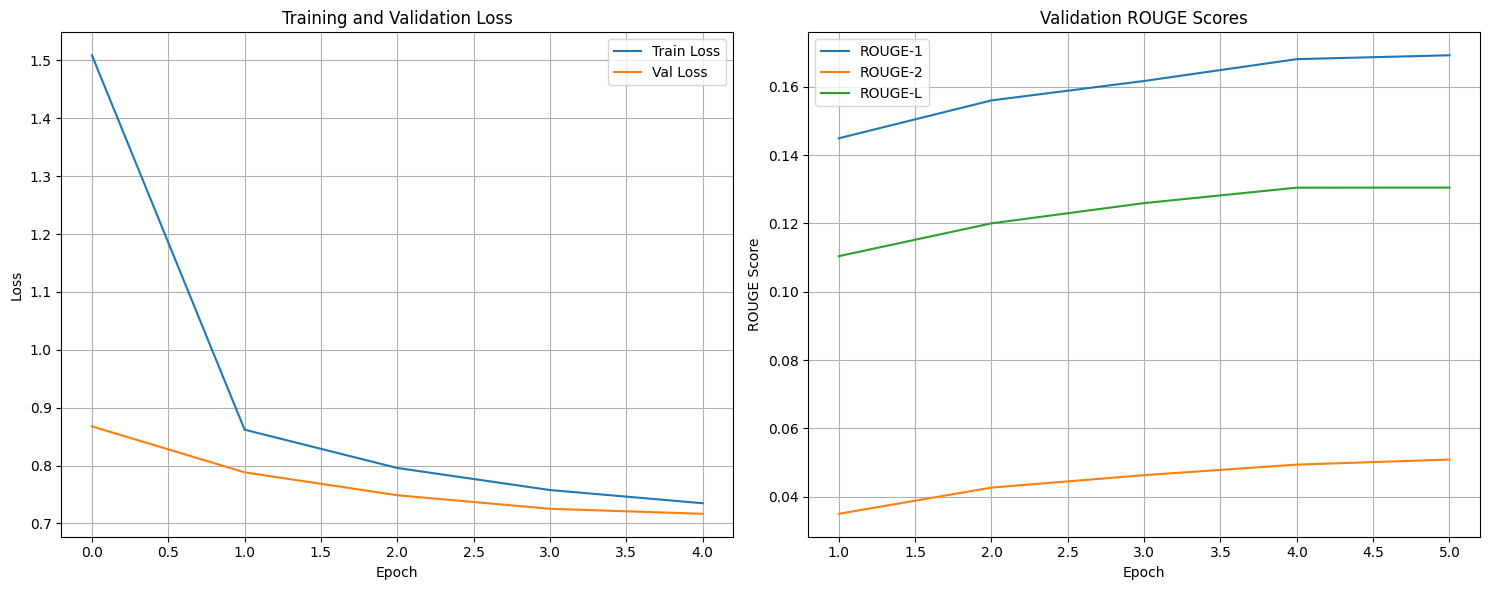

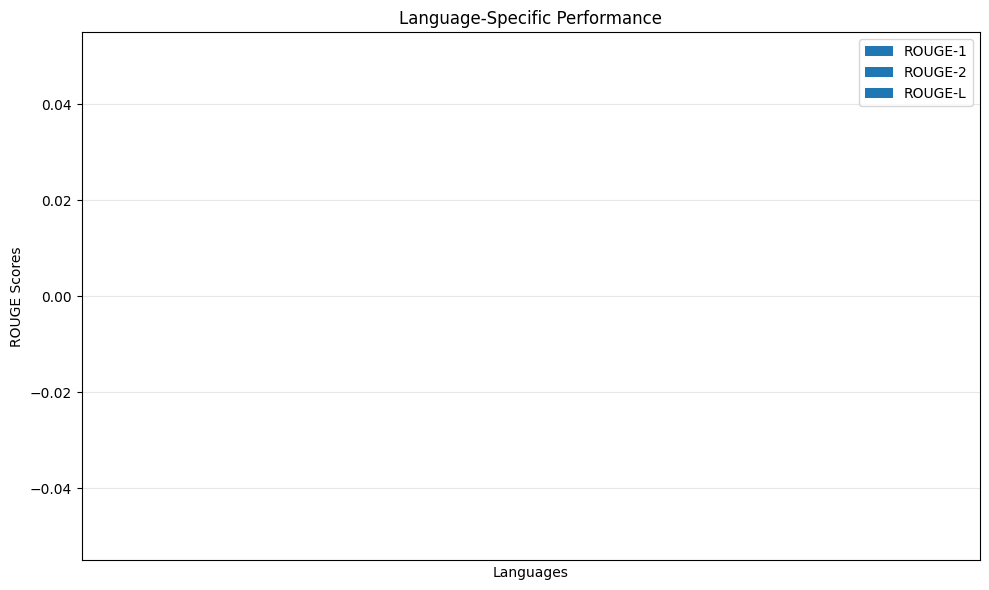

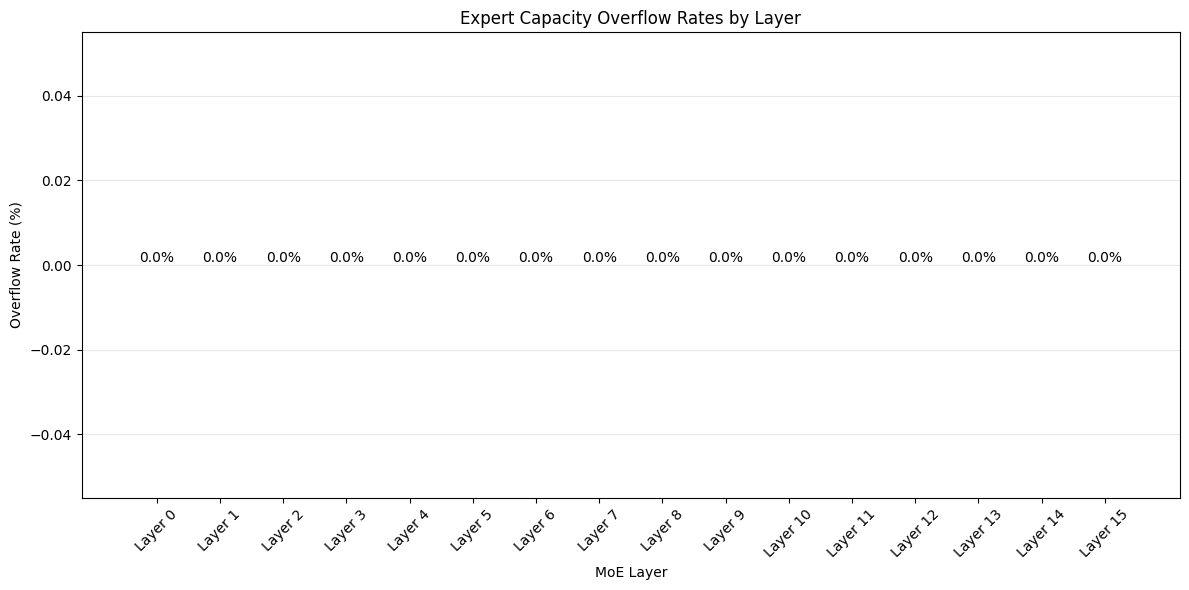


--- Expert Usage Summary ---
Average overflow rate: 0.00%
Max overflow rate: 0.00%
Layers with overflow: 0/16


In [28]:
print("Plotting results...")
plot_training_curves(training_history)
plot_language_performance(language_rouge)
plot_expert_usage(model)

In [29]:
print("\n" + "=" * 80)
print(f"\nModel Configuration:")
print(f"- Base Model: {config.model_name}")
print(f"- Languages: {', '.join(config.languages)}")
print(f"- Number of Experts: {config.num_experts}")
print(f"- Top-K Routing: {config.top_k}")
print(f"- Batch Size: {config.batch_size}")
print(f"- Learning Rate: {config.learning_rate}")
print(f"- Training Epochs: {config.num_epochs}")

print(f"\nTraining Results:")
print(
    f"- Total Training Time: {training_history['training_time']:.2f} seconds")
print(f"- Final Training Loss: {training_history['train_losses'][-1]:.4f}")
print(f"- Final Validation Loss: {training_history['val_losses'][-1]:.4f}")

print(f"\nOverall Test Performance (ROUGE Scores):")
print(f"- ROUGE-1: {overall_rouge['rouge1']:.4f}")
print(f"- ROUGE-2: {overall_rouge['rouge2']:.4f}")
print(f"- ROUGE-L: {overall_rouge['rougeL']:.4f}")

print(f"\nLanguage-Specific Performance:")
for lang, scores in language_rouge.items():
    print(
        f"- {lang.upper()}: ROUGE-1={scores['rouge1']:.4f}, ROUGE-2={scores['rouge2']:.4f}, ROUGE-L={scores['rougeL']:.4f}"
    )

print(f"\nDataset Statistics:")
print(f"- Training samples: {len(train_data)}")
print(f"- Validation samples: {len(val_data)}")
print(f"- Test samples: {len(test_data)}")
print(
    f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n" + "=" * 80)



Model Configuration:
- Base Model: google/mt5-small
- Languages: english, hindi, punjabi
- Number of Experts: 6
- Top-K Routing: 3
- Batch Size: 32
- Learning Rate: 0.0003
- Training Epochs: 5

Training Results:
- Total Training Time: 26212.41 seconds
- Final Training Loss: 0.7349
- Final Validation Loss: 0.7167

Overall Test Performance (ROUGE Scores):
- ROUGE-1: 0.1700
- ROUGE-2: 0.0518
- ROUGE-L: 0.1315

Language-Specific Performance:

Dataset Statistics:
- Training samples: 385515
- Validation samples: 21408
- Test samples: 21408
- Total parameters: 476,620,256



In [30]:
print("--- Loading Best Model for Sample Inference ---")

# Clear CUDA cache first to avoid errors
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

try:
    loaded_checkpoint = load_best_model(model, tokenizer)
    if loaded_checkpoint:
        print("\nPerforming sample inferences with the best loaded model...")
        model.eval()

        sample_texts = {
            "english": "The quick brown fox jumps over the lazy dog, showcasing its agility and speed. This particular sentence is not just a whimsical phrase; it is a classic pangram that contains every letter of the English alphabet at least once. It has been used for decades to test typewriters, keyboards, and fonts.",
            "hindi": "भारत एक महान देश है जिसका इतिहास सहस्राब्दियों पुराना है। यह विभिन्न संस्कृतियों, भाषाओं, और धर्मों का घर है। भारतीय सभ्यता विश्व की प्राचीनतम सभ्यताओं में से एक है और इसने विज्ञान, गणित, कला और दर्शन के क्षेत्र में महत्वपूर्ण योगदान दिया है।",
            "punjabi": "ਪੰਜਾਬ ਭਾਰਤ ਦਾ ਇੱਕ ਪ੍ਰਮੁੱਖ ਰਾਜ ਹੈ ਜੋ ਆਪਣੇ ਹਰੇ-ਭਰੇ ਖੇਤਾਂ ਅਤੇ ਉਪਜਾਊ ਜ਼ਮੀਨ ਲਈ ਜਾਣਿਆ ਜਾਂਦਾ ਹੈ। ਇੱਥੇ ਦੇ ਲੋਕ ਆਪਣੀ ਮਿਹਨਤ, ਖੁਸ਼ਮਿਜ਼ਾਜੀ ਅਤੇ ਗਰਮਜੋਸ਼ੀ ਲਈ ਮਸ਼ਹੂਰ ਹਨ। ਪੰਜਾਬੀ ਸੱਭਿਆਚਾਰ ਸੰਗੀਤ, ਨਾਚ ਅਤੇ ਭੋਜਨ ਦੇ ਲਈ ਵਿਸ਼ਵ ਭਰ ਵਿੱਚ ਪ੍ਰਸਿੱਧ ਹੈ।",
        }

        lang_token_map = {"english": "<en>", "hindi": "<hi>", "punjabi": "<pa>"}
        lang_id_map = {"english": "en", "hindi": "hi", "punjabi": "pa"}
        
        # Extract model for generation (handle DataParallel wrapper)
        model_to_generate = model.module if hasattr(model, "module") else model

        for lang, text in sample_texts.items():
            try:
                input_text_with_token = f"{lang_token_map[lang]} summarize: {text}"

                input_encoding = tokenizer(
                    input_text_with_token,
                    max_length=config.max_input_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt",
                )

                input_ids = input_encoding.input_ids.to(device)
                attention_mask = input_encoding.attention_mask.to(device)

                with torch.no_grad():
                    # Use beam search for quality (config.num_beams)
                    # Set language_ids for proper MoE routing
                    model_to_generate.current_language_ids = [lang_id_map[lang]]
                    
                    generated_ids = model_to_generate.base_model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_length=config.max_target_length,
                        num_beams=config.num_beams,  # Use config beam search setting
                        early_stopping=True,
                    )

                summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

                print(f"\n--- Sample Inference for {lang.upper()} ---")
                print(f"Input: {text[:100]}...")  # Show first 100 chars
                print(f"Generated Summary: {summary}")
                print("-" * 50)
                
            except Exception as e:
                print(f"\n[Error] Failed to generate summary for {lang}: {str(e)}")
                # Clear CUDA cache on error
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                continue
                
    else:
        print("\nCould not load the best model for sample inference.")
        print("This may be because training hasn't been run yet or checkpoint is missing.")
        
except FileNotFoundError as e:
    print(f"\n[Error] Checkpoint file not found: {str(e)}")
    print("Please run the training cells first to generate a checkpoint.")
except Exception as e:
    print(f"\n[Error] Unexpected error during inference: {str(e)}")
    import traceback
    traceback.print_exc()

--- Loading Best Model for Sample Inference ---
Loading best model from ./best_model/best_model.pt
Best model loaded successfully!
Best rougeL score: 0.1305
From epoch: 3

Performing sample inferences with the best loaded model...

[Error] Failed to generate summary for english: CUDA error: CUBLAS_STATUS_INTERNAL_ERROR when calling `cublasSgemmStridedBatched( handle, opa, opb, m, n, k, &alpha, a, lda, stridea, b, ldb, strideb, &beta, c, ldc, stridec, num_batches)`

[Error] Unexpected error during inference: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.



Traceback (most recent call last):
  File "/tmp/ipykernel_179084/396035318.py", line 46, in <module>
    generated_ids = model_to_generate.base_model.generate(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py", line 1597, in generate
    model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/transformers/generation/utils.py", line 523, in _prepare_encoder_decoder_kwargs_for_generation
    model_kwargs["encoder_outputs"]: ModelOutput = encoder(**encoder_kwargs)
                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modu

In [31]:
def continue_training(
    model, 
    train_loader, 
    val_loader, 
    tokenizer, 
    additional_epochs, 
    checkpoint_path=None,
    new_learning_rate=None,
    reset_optimizer=False
):
    """
    Continue training from a checkpoint for additional epochs.
    
    Args:
        model: The model to continue training
        train_loader: Training data loader
        val_loader: Validation data loader
        tokenizer: Tokenizer for decoding
        additional_epochs: Number of additional epochs to train
        checkpoint_path: Path to checkpoint to resume from (default: best_model/best_model.pt)
        new_learning_rate: Optional new learning rate (default: use config.learning_rate)
        reset_optimizer: If True, creates new optimizer instead of loading from checkpoint
    
    Returns:
        Updated training_history dictionary
    """
    
    # Load checkpoint if path provided, otherwise use best model
    if checkpoint_path is None:
        checkpoint_path = os.path.join(config.checkpoint_dir, "best_model", "best_model.pt")
    
    print(f"\n{'='*80}")
    print(f"CONTINUING TRAINING FOR {additional_epochs} MORE EPOCHS")
    print(f"{'='*80}")
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    
    # Get previous training history
    previous_history = checkpoint.get("training_history", {
        "train_losses": [],
        "val_losses": [],
        "val_rouge_scores": [],
        "training_time": 0
    })
    
    start_epoch = checkpoint["epoch"] + 1
    
    print(f"Previous training: {checkpoint['epoch'] + 1} epochs completed")
    print(f"Best ROUGE-L so far: {checkpoint['rouge_scores']['rougeL']:.4f}")
    print(f"Previous training time: {previous_history.get('training_time', 0)/60:.1f} minutes")
    
    # Setup optimizer
    if reset_optimizer or new_learning_rate:
        lr = new_learning_rate if new_learning_rate else config.learning_rate
        print(f"\nCreating new optimizer with LR={lr:.2e}")
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=config.weight_decay)
    else:
        print(f"\nRestoring optimizer from checkpoint")
        optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    # Setup scheduler for additional epochs
    total_steps = len(train_loader) * additional_epochs
    # Reduced warmup for continued training (10% of original)
    warmup_steps = max(100, config.warmup_steps // 10)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
    )
    
    print(f"Total additional steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")
    
    # Initialize GradScaler
    scaler = torch.cuda.amp.GradScaler(
        init_scale=2**10,
        growth_factor=2.0,
        backoff_factor=0.5,
        growth_interval=100
    )
    
    # Initialize checkpoint manager
    checkpoint_manager = ModelCheckpoint(
        checkpoint_dir=config.checkpoint_dir,
        save_best_only=config.save_best_only,
        best_metric=config.best_metric,
        patience=config.patience,
        min_delta=config.min_delta,
    )
    
    # Restore checkpoint manager state
    checkpoint_manager.best_score = checkpoint.get("best_score", checkpoint["rouge_scores"][config.best_metric])
    checkpoint_manager.best_epoch = checkpoint.get("best_epoch", checkpoint["epoch"])
    
    # Copy previous history
    train_losses = previous_history["train_losses"].copy()
    val_losses = previous_history["val_losses"].copy()
    val_rouge_scores = previous_history["val_rouge_scores"].copy()
    
    print(f"\n{'='*80}")
    print("Starting continued training...")
    print(f"{'='*80}\n")
    
    start_time = time.time()
    global_step = 0
    
    for epoch in range(start_epoch, start_epoch + additional_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{start_epoch + additional_epochs} (Overall Epoch {epoch+1})")
        print(f"{'='*60}")
        
        model.train()
        epoch_loss = 0
        batches_processed = 0
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages
                )
                
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
            
            # Backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_val)
            scaler.step(optimizer)
            scale = scaler.get_scale()
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
            
            # Check for gradient overflow
            skip_step = (scaler.get_scale() < scale)
            if skip_step and global_step > warmup_steps:
                print(f"[Info] Gradient overflow at step {global_step} - optimizer step skipped")
            
            epoch_loss += loss.item()
            batches_processed += 1
            global_step += 1
            
            # Log training progress
            if global_step % config.LOG_INTERVALS == 0:
                print(f"Step {global_step} | Batch {batch_idx+1}/{len(train_loader)} | Train Loss: {loss.item():.4f}")
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / max(batches_processed, 1)
        train_losses.append(avg_train_loss)
        
        # End-of-epoch validation
        print(f"\n{'='*60}")
        print(f"End-of-Epoch {epoch+1} Validation")
        print(f"{'='*60}")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        model.eval()
        eoe_val_loss = 0
        eoe_val_predictions = []
        eoe_val_references = []
        eoe_batches_processed = 0
        eoe_generation_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                languages = batch["language"]
                
                with torch.cuda.amp.autocast():
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        language_ids=languages
                    )
                
                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                eoe_val_loss += loss.item()
                eoe_batches_processed += 1
                
                # Generate predictions for ROUGE
                if eoe_generation_batches < config.max_val_generation_batches:
                    pred_texts, ref_texts = generate_and_decode(
                        model, input_ids, attention_mask, labels, tokenizer
                    )
                    
                    if pred_texts is not None:
                        eoe_val_predictions.extend(pred_texts)
                        eoe_val_references.extend(ref_texts)
                    eoe_generation_batches += 1
        
        avg_eoe_val_loss = eoe_val_loss / max(eoe_batches_processed, 1)
        val_losses.append(avg_eoe_val_loss)
        
        # Calculate ROUGE scores
        eoe_rouge_scores = calculate_rouge_scores(
            eoe_val_predictions, eoe_val_references
        ) if eoe_val_predictions else {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
        
        val_rouge_scores.append(eoe_rouge_scores)
        
        # Update training history
        total_training_time = previous_history.get("training_time", 0) + (time.time() - start_time)
        training_history = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_rouge_scores": val_rouge_scores,
            "training_time": total_training_time,
        }
        
        print(f"\n--- Epoch {epoch+1} Summary ---")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_eoe_val_loss:.4f}")
        print(f"ROUGE-1: {eoe_rouge_scores['rouge1']:.4f}, ROUGE-2: {eoe_rouge_scores['rouge2']:.4f}, ROUGE-L: {eoe_rouge_scores['rougeL']:.4f}")
        print(f"Elapsed Time: {(time.time() - start_time)/60:.1f} minutes")
        print(f"Total Training Time: {total_training_time/60:.1f} minutes")
        print(f"{'='*60}\n")
        
        # Save checkpoint
        checkpoint_manager.save_checkpoint(
            model,
            optimizer,
            scheduler,
            epoch,
            avg_train_loss,
            avg_eoe_val_loss,
            eoe_rouge_scores,
            training_history,
        )
        
        # Check for early stopping
        if checkpoint_manager.should_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Update final metadata
    final_training_time = previous_history.get("training_time", 0) + (time.time() - start_time)
    training_history["training_time"] = final_training_time
    training_history["training_complete"] = True
    
    metadata = {
        "best_score": checkpoint_manager.best_score,
        "best_epoch": checkpoint_manager.best_epoch,
        "final_epoch": epoch,
        "training_complete": True,
        "total_training_time": final_training_time,
    }
    
    with open(os.path.join(config.checkpoint_dir, "training_metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\n{'='*80}")
    print(f"Continued Training Completed!")
    print(f"{'='*80}")
    print(f"Additional epochs trained: {additional_epochs}")
    print(f"Total epochs: {epoch + 1}")
    print(f"Best {config.best_metric}: {checkpoint_manager.best_score:.4f} (Epoch {checkpoint_manager.best_epoch + 1})")
    print(f"Additional training time: {(time.time() - start_time)/60:.1f} minutes")
    print(f"Total training time: {final_training_time/60:.1f} minutes")
    print(f"{'='*80}\n")
    
    return training_history

print("✅ continue_training() function loaded")

✅ continue_training() function loaded


../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [0,0,0], thread

In [32]:
def reevaluate_and_plot(model, test_loader, tokenizer, training_history):
    """
    Re-evaluate the model on test set and plot updated training curves.
    
    Args:
        model: The trained model
        test_loader: Test data loader
        tokenizer: Tokenizer for decoding
        training_history: Updated training history dictionary
    
    Returns:
        Dictionary with overall and per-language ROUGE scores
    """
    
    print("\n" + "="*80)
    print("RE-EVALUATING MODEL ON TEST SET")
    print("="*80)
    
    # Load best model
    best_model_path = os.path.join(config.checkpoint_dir, "best_model", "best_model.pt")
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")
        print(f"Best ROUGE-L: {checkpoint['rouge_scores']['rougeL']:.4f}")
    else:
        print("Warning: Best model not found, using current model state")
    
    # Evaluate on test set
    eval_results = evaluate_model(model, test_loader, tokenizer)
    overall_rouge = eval_results["overall"]
    language_rouge = eval_results["per_language"]
    
    # Plot updated training curves
    print("\n" + "="*80)
    print("PLOTTING UPDATED TRAINING CURVES")
    print("="*80)
    
    plot_training_curves(training_history)
    plot_language_performance(language_rouge)
    plot_expert_usage(model)
    
    # Print summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"\nTotal Training Epochs: {len(training_history['train_losses'])}")
    print(f"Total Training Time: {training_history['training_time']/3600:.2f} hours")
    
    print(f"\nOverall Test Performance:")
    print(f"  ROUGE-1: {overall_rouge['rouge1']:.4f}")
    print(f"  ROUGE-2: {overall_rouge['rouge2']:.4f}")
    print(f"  ROUGE-L: {overall_rouge['rougeL']:.4f}")
    
    print(f"\nPer-Language Performance:")
    for lang, scores in language_rouge.items():
        print(f"  {lang.upper()}: R-1={scores['rouge1']:.4f}, R-2={scores['rouge2']:.4f}, R-L={scores['rougeL']:.4f}")
    
    print(f"\nBest Validation ROUGE-L: {max([s['rougeL'] for s in training_history['val_rouge_scores']]):.4f}")
    print(f"Final Validation ROUGE-L: {training_history['val_rouge_scores'][-1]['rougeL']:.4f}")
    print("="*80 + "\n")
    
    return eval_results

print("✅ reevaluate_and_plot() function loaded")

✅ reevaluate_and_plot() function loaded


In [33]:
def run_sample_inference_updated(model, tokenizer, sample_texts=None):
    """
    Run sample inference with the current model state.
    
    Args:
        model: The trained model
        tokenizer: Tokenizer for encoding/decoding
        sample_texts: Optional dictionary of sample texts by language
                     If None, uses default samples
    
    Returns:
        Dictionary of generated summaries by language
    """
    
    print("\n" + "="*80)
    print("RUNNING SAMPLE INFERENCE WITH UPDATED MODEL")
    print("="*80)
    
    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    # Load best model
    best_model_path = os.path.join(config.checkpoint_dir, "best_model", "best_model.pt")
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")
        print(f"Best ROUGE-L: {checkpoint['rouge_scores']['rougeL']:.4f}\n")
    
    # Default sample texts if not provided
    if sample_texts is None:
        sample_texts = {
            "english": "The quick brown fox jumps over the lazy dog, showcasing its agility and speed. This particular sentence is not just a whimsical phrase; it is a classic pangram that contains every letter of the English alphabet at least once. It has been used for decades to test typewriters, keyboards, and fonts.",
            "hindi": "भारत एक महान देश है जिसका इतिहास सहस्राब्दियों पुराना है। यह विभिन्न संस्कृतियों, भाषाओं, और धर्मों का घर है। भारतीय सभ्यता विश्व की प्राचीनतम सभ्यताओं में से एक है और इसने विज्ञान, गणित, कला और दर्शन के क्षेत्र में महत्वपूर्ण योगदान दिया है।",
            "punjabi": "ਪੰਜਾਬ ਭਾਰਤ ਦਾ ਇੱਕ ਪ੍ਰਮੁੱਖ ਰਾਜ ਹੈ ਜੋ ਆਪਣੇ ਹਰੇ-ਭਰੇ ਖੇਤਾਂ ਅਤੇ ਉਪਜਾਊ ਜ਼ਮੀਨ ਲਈ ਜਾਣਿਆ ਜਾਂਦਾ ਹੈ। ਇੱਥੇ ਦੇ ਲੋਕ ਆਪਣੀ ਮਿਹਨਤ, ਖੁਸ਼ਮਿਜ਼ਾਜੀ ਅਤੇ ਗਰਮਜੋਸ਼ੀ ਲਈ ਮਸ਼ਹੂਰ ਹਨ। ਪੰਜਾਬੀ ਸੱਭਿਆਚਾਰ ਸੰਗੀਤ, ਨਾਚ ਅਤੇ ਭੋਜਨ ਦੇ ਲਈ ਵਿਸ਼ਵ ਭਰ ਵਿੱਚ ਪ੍ਰਸਿੱਧ ਹੈ।",
        }
    
    lang_token_map = {"english": "<en>", "hindi": "<hi>", "punjabi": "<pa>"}
    lang_id_map = {"english": "en", "hindi": "hi", "punjabi": "pa"}
    
    model.eval()
    model_to_generate = model.module if hasattr(model, "module") else model
    
    generated_summaries = {}
    
    for lang, text in sample_texts.items():
        try:
            input_text_with_token = f"{lang_token_map[lang]} summarize: {text}"
            
            input_encoding = tokenizer(
                input_text_with_token,
                max_length=config.max_input_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            
            input_ids = input_encoding.input_ids.to(device)
            attention_mask = input_encoding.attention_mask.to(device)
            
            with torch.no_grad():
                # Set language_ids for proper MoE routing
                model_to_generate.current_language_ids = [lang_id_map[lang]]
                
                generated_ids = model_to_generate.base_model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=config.max_target_length,
                    num_beams=config.num_beams,
                    early_stopping=True,
                )
            
            summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            generated_summaries[lang] = summary
            
            print(f"\n--- Sample Inference for {lang.upper()} ---")
            print(f"Input: {text[:100]}...")
            print(f"Generated Summary: {summary}")
            print("-" * 80)
            
        except Exception as e:
            print(f"\n[Error] Failed to generate summary for {lang}: {str(e)}")
            generated_summaries[lang] = None
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            continue
    
    print("\n" + "="*80 + "\n")
    return generated_summaries

print("✅ run_sample_inference_updated() function loaded")

✅ run_sample_inference_updated() function loaded


In [34]:
# Example 1: Continue training for 2 more epochs with same settings
# Uncomment to run:

# training_history = continue_training(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     tokenizer=tokenizer,
#     additional_epochs=2,
#     checkpoint_path=None,  # Uses best model by default
#     new_learning_rate=None,  # Uses config.learning_rate
#     reset_optimizer=False  # Continue with saved optimizer state
# )

print("Example 1: Continue training for N more epochs (uncomment to run)")

Example 1: Continue training for N more epochs (uncomment to run)


In [35]:
# Example 2: Continue training with a lower learning rate (fine-tuning)
# Uncomment to run:

# training_history = continue_training(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     tokenizer=tokenizer,
#     additional_epochs=3,
#     checkpoint_path=None,
#     new_learning_rate=1e-4,  # Lower LR for fine-tuning (was 3e-4)
#     reset_optimizer=True  # Start with fresh optimizer
# )

print("Example 2: Fine-tune with lower learning rate (uncomment to run)")

Example 2: Fine-tune with lower learning rate (uncomment to run)


In [36]:
# Example 3: Re-evaluate and plot after continued training
# Uncomment to run:

# eval_results = reevaluate_and_plot(
#     model=model,
#     test_loader=test_loader,
#     tokenizer=tokenizer,
#     training_history=training_history
# )
# 
# overall_rouge = eval_results["overall"]
# language_rouge = eval_results["per_language"]

print("Example 3: Re-evaluate and plot results (uncomment to run)")

Example 3: Re-evaluate and plot results (uncomment to run)


In [37]:
# Example 4: Run sample inference with updated model
# Uncomment to run:

# summaries = run_sample_inference_updated(
#     model=model,
#     tokenizer=tokenizer,
#     sample_texts=None  # Uses default samples, or provide your own dict
# )
# 
# # Access individual summaries
# # print(f"English summary: {summaries['english']}")
# # print(f"Hindi summary: {summaries['hindi']}")
# # print(f"Punjabi summary: {summaries['punjabi']}")

print("Example 4: Run sample inference (uncomment to run)")

Example 4: Run sample inference (uncomment to run)


In [38]:
# ==================================================================================
# QUICK START: Uncomment the block below to continue training for N more epochs
# ==================================================================================

# # STEP 1: Continue training (adjust additional_epochs as needed)
# print("\n" + "="*80)
# print("STARTING CONTINUED TRAINING")
# print("="*80 + "\n")
# 
# training_history = continue_training(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     tokenizer=tokenizer,
#     additional_epochs=2,  # ← Change this to train for more/fewer epochs
#     checkpoint_path=None,  # Uses best model automatically
#     new_learning_rate=None,  # Set to 1e-4 for fine-tuning, or None to keep original
#     reset_optimizer=False  # Set True if using new_learning_rate
# )
# 
# # STEP 2: Re-evaluate and plot
# eval_results = reevaluate_and_plot(
#     model=model,
#     test_loader=test_loader,
#     tokenizer=tokenizer,
#     training_history=training_history
# )
# 
# # STEP 3: Run sample inference
# summaries = run_sample_inference_updated(
#     model=model,
#     tokenizer=tokenizer
# )
# 
# print("\n" + "="*80)
# print("✅ CONTINUED TRAINING COMPLETE!")
# print("="*80)

print("💡 Uncomment the code block above to continue training for additional epochs")

💡 Uncomment the code block above to continue training for additional epochs
